<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Classification error metrics

In this notebook we will be applying classification metrics to evaluate the performance of a classifier model.  We will again use the sonar dataset we have previously used.  Details on the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_data(url):
    # Load the data
    data = pd.read_csv(url, header=None)

    # Separate into X and y 
    # Create feature matrix using the first 60 columns as the features
    X = data.iloc[:,:60].to_numpy()
    # Create target vector from the last column
    y = data.iloc[:,60].to_numpy()

    # Covert the labels to 0s and 1s
    y = np.where(y=='M',1,0)

    return X,y

X,y = load_data('https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv')

In [3]:
def split(X,y,pct):
    # Split the data into training and test sets
    X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=pct)
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split(X,y,pct=0.4)

We will train a MLP model on the data and then get the predictions for the test set.

In [4]:
# Set up the MLP classifier model
model = MLPClassifier(hidden_layer_sizes=(100,50),activation='relu',
                      solver='sgd',learning_rate_init=0.01,max_iter=1000)

# Train the model on the training data
model.fit(X_train,y_train)

# Get the predictions for the test data to compute error metrics
test_preds = model.predict(X_test)

Now we are ready to compute our error metrics.  Let's start by displaying the confusion matrix

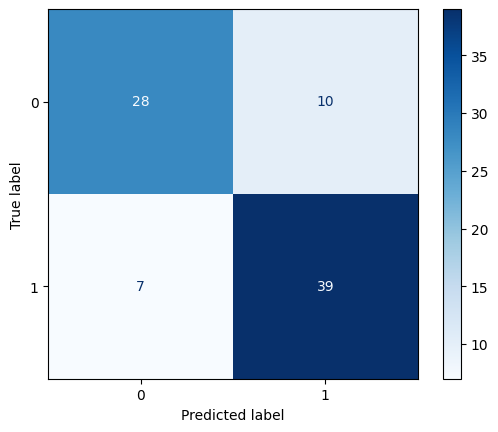

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, test_preds, normalize=None, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Question: what is more important to us, minimizing false positives or false negatives?
### Therefore, which metric should we pay more attention to - precision or recall?

In [6]:
# Compute the accuracy, precision and recall for the target class ('1')
from sklearn.metrics import accuracy_score,recall_score,precision_score
def print_metrics(y_test,preds):
    print('Accuracy: {:.3f}'.format(accuracy_score(y_test,preds)))
    print('Recall: {:.3f}'.format(recall_score(y_test,preds)))
    print('Precision: {:.3f}'.format(precision_score(y_test,preds)))
    return

print_metrics(test_preds,y_test)

Accuracy: 0.798
Recall: 0.796
Precision: 0.848


In [7]:
# Alternatively, simply use sklearn's classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,test_preds))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77        38
           1       0.80      0.85      0.82        46

    accuracy                           0.80        84
   macro avg       0.80      0.79      0.79        84
weighted avg       0.80      0.80      0.80        84



### Adjusting threshold values
Now let's change the threshold value for classification of something as a mine ('1') and see how it impacts our metrics

In [8]:
# Get the predicted probabilities of class "1"
test_preds_prob = model.predict_proba(X_test)
test_preds_prob1 = test_preds_prob[:,1]

# Use a threshold=0.1 to get discreet predictions from the probabilities
thresh = 0.1
test_preds_thresh = (test_preds_prob1>=thresh).astype(int)

# Calculate metrics
print_metrics(y_test,test_preds_thresh)

Accuracy: 0.786
Recall: 0.957
Precision: 0.733


In [9]:
# Use a threshold=0.9 to get discreet predictions from the probabilities
thresh = 0.9
test_preds_thresh = (test_preds_prob1>=thresh).astype(int)

# Calculate metrics
print_metrics(y_test,test_preds_thresh)

Accuracy: 0.798
Recall: 0.761
Precision: 0.854


### ROC Curve

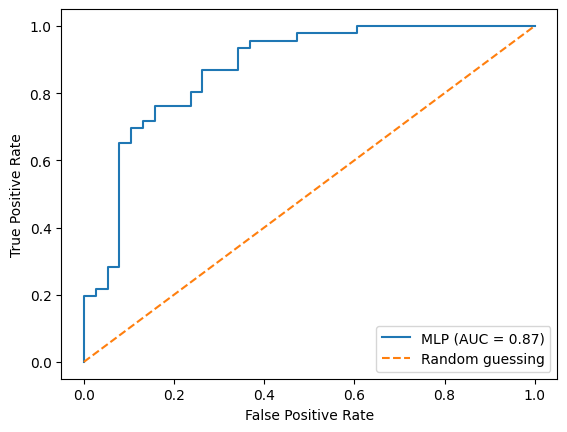

In [10]:
# Plot the ROC curve
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
fpr, tpr, thresholds = roc_curve(y_test, test_preds_prob1)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='MLP')
roc_display.plot()
# Add a line to show the curve for random guessing
plt.plot([0,1],[0,1],linestyle='--',label='Random guessing')
plt.legend()
plt.show()

### Precision-Recall Curve

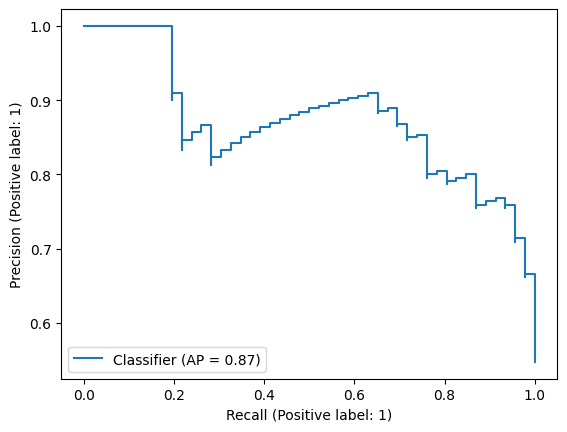

In [11]:
# Plot the precision-recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test, test_preds_prob1)
plt.show()